# Qdrant 101

![qdrant](https://qdrant.tech/images/logo_with_text.png)

Vector databases are a "relatively" new way for interacting with abstract data representations derived from opaque machine learning models -- deep learning architectures being the most common ones. These representations are often called vectors or embeddings and they are a compressed version of the data used to train a machine learning model to accomplish a task (e.g., sentiment analysis, speech recognition, object detection, and many more).

Vector databases shine in many applications like semantic search and recommendation systems, and in this tutorial, we'll learn about how to get started with one of the most popular and fastest growing vector databases in the market, Qdrant.

## Table of Contents

1. Learning Outcomes
2. What is Qdrant?
    - What are Vector Databases?
    - Why do We Need Vector Databases??
    - Overview of Qdrant's Architecture    
    - How do We Get Started?
3. Getting Started
    - Adding Points
    - Payload
    - Search
4. NLP & Vector Databases
    - The Data
    - The Model
    - The Vectors
    - Semantic Search with Qdrant
    - Fine-Tunning
7. Conclusion

## 1. Learning Outcomes

By the end of this tutorial, you will be able
- Describe what are vector databases and what are they used for.
- Extract vectors from text text data.
- Create, update, and query collections of vectors using Qdrant.
- Fine-tune a model on your own dataset and create better vectors.
- Visualize your collections of data.

## 2. What is Qdrant?

Qdrant "is a vector similarity search engine that provides a production-ready service with a convenient API to store, search, and manage points (i.e. vectors) with an additional payload." You can get started with plain python using the `qdrant-client`, pull the latest docker image of `qdrant` and connect to it locally, or try out Qdrant's Cloud free tier option until you are ready to make the full switch.

### 2.1 What Are Vector Databases?

A vector database is a type of database designed to store and query high-dimensional vectors efficiently. In traditional [OLTP](https://www.ibm.com/topics/oltp) and [OLAP](https://www.ibm.com/topics/olap) databases, data is organized in rows and columns, and queries are performed based on the values in those columns. However, in certain applications including image recognition, natural language processing, and recommendation systems, data is often represented as vectors in a high-dimensional space. Here is a depiction of all three next to each other.

![dbs](../images/databases.png)

A vector in this context is a mathematical representation of an object or data point, where each element of the vector corresponds to a specific feature or attribute of the object. For example, in an image recognition system, a vector could represent an image, with each element of the vector representing a pixel value or a descriptor/characteristic of that pixel.

Vector databases are optimized for **storing** and **querying** these high-dimensional vectors efficiently, often using specialized data structures and indexing techniques such as Hierarchical Navigable Small World (HNSW), Approximate Nearest Neighbors, and Product Quantization, among others. These databases enable fast similarity and semantic search while allowing users to find vectors that are the closest to a given query vector based on some distance metric. The most commonly used distance metrics are Euclidean Distance, Cosine Similarity, and Dot Product.

### 2.2 Why do we need Vector Databases?

Vector databases play a crucial role in various applications that require similarity search, such as recommendation systems, content-based image retrieval, and personalized search. By taking advantage of their efficient indexing and searching techniques, vector databases enable faster and more accurate retrieval of similar vectors, which helps advance data analysis and decision-making.

In addition, other benefits of using vector databases include:
1. Efficient storage and indexing of high-dimensional data.
3. Ability to handle large-scale datasets with billions or trillions of data points.
4. Support for real-time analytics and queries.
5. Ability to handle complex data types, such as images, videos, and natural language text.
6. Improved performance and reduced latency in machine learning and AI applications.
7. Reduced development and deployment time and cost compared to building a custom solution.

Keep in mind that the specific benefits of using a vector database may vary depending on the use case of your organization and the features of the database.

### 2.3 Overview of Qdrant's Architecture (High-Level)

![qdrant](../images/qdrant_overview_high_level.png)

The diagram above represents a high-level overview of some of the main components of Qdrant. Here are the terminologies you should get familiar with.

- [Collections](https://qdrant.tech/documentation/collections/): A collection is a named set of points (vectors with a payload) among which you can search. Vectors within the same collection must have the same dimensionality and be compared by a single metric.
- Distance Metrics: These are used to measure similarities among vectors and they must be selected at the same time you are creating a collection. The choice of metric depends on the way vectors obtaining and, in particular, on the method of neural network encoder training.
- [Points](https://qdrant.tech/documentation/points/): The points are the central entity that Qdrant operates with and they consist of a vector and an optional id and payload.
- id: a unique identifier for your vectors.
- Vector: a high-dimensional representation of data, for example, an image, a sound, a document, a video, etc.
- [Payload](https://qdrant.tech/documentation/payload/): A payload additional data you can add to a vector.
- [Storage](https://qdrant.tech/documentation/storage/): Qdrant can use one of  two options for storage, **In-memory** storage (Stores all vectors in RAM, has the highest speed since disk access is required only for persistence), or **Memmap** storage, (creates a virtual address space associated with the file on disk).
- Clients: the programming languages you can use to connect to Qdrant.

### 2.4 How do we get started?

The open source version of Qdrant is available as a docker image and it can be pulled and run from any machine with docker installed. If you don't have Docker installed in your PC you can follow the instructions in the official documentation [here](https://docs.docker.com/get-docker/). After that, open your terminal start by downloading the image with the following command.

```sh
docker pull qdrant/qdrant
```

Next, initialize Qdrant with the following command, and you should be good to go.

```sh
docker run -p 6333:6333 \
    -v $(pwd)/qdrant_storage:/qdrant/storage \
    qdrant/qdrant
```

You should see something similar to the following image.

![dockerqdrant](../images/docker_qdrant.png)

If you experience any issues during the start process, please let us know in our [discord channel here](https://qdrant.to/discord). We are always available and happy to help.

Now that you have Qdrant up and running, your next step is to pick a client to connect to it. We'll be using Python as it has the most mature data tools' ecosystem out there. Therefore, let's start setting up our dev environment and getting the libraries we'll be using today.

```sh
# with mamba or conda
mamba env create -n my_env python=3.10
mamba activate my_env

# or with virtualenv
python -m venv venv
source venv/bin/activate

# install packages
pip install qdrant-client transformers datasets pandas numpy torch
```

After your have your environment ready, let's get started with Qdrant.

**Note:** At the time of writing, Qdrant supports Rust, GO, Python and TypeScript. We might see other programming languages being added in the future.

## 3. Getting Started

The two modules we'll use the most are the `QdrantClient` and the `models` one. The former allows us to connect to Qdrant or it allows us to run an in-memory database by switching the parameter `host=` to `":memory:"` (this is a great feature for testing in a CI/CD pipeline). We'll start by instantiating our client using `host="localhost"` and `port=6333` (as it is the default we used earlier with docker).

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import CollectionStatus

In [ ]:
client = QdrantClient(host="localhost", port=6333)
client

In OLTP and OLAP databases we call specific bundles of rows and columns **Tables**, but in vector databases the rows are known as vectors, the columns are known as dimensions, and the combination of the two (plus some metadata) as **collections**.

In the same way in which we can create many tables in a database, we can create many collections in a vector-based database using a client. The key difference to note is that when we create a collection, we need to specify the width of the collection (i.e. the length of the vector or amount of dimensions) beforehand with the parameter `size=...`, as well as the similarity metric with the parameter `distance=...` (which can be changed later on).

The distances currently supported by Qdrant are:
- [**Cosine Similarity**](https://en.wikipedia.org/wiki/Cosine_similarity) - Cosine similarity is a way to measure how similar two things are. Think of it like a ruler that tells you how far apart two points are, but instead of measuring distance, it measures how similar two things are. It's often used with text to compare how similar two documents or sentences are to each other. The output of the cosine similarity ranges from 0 to 1, where 0 means the two things are completely dissimilar, and 1 means the two things are exactly the same. It's a straightforward and effective way to compare two things!
- [**Dot Product**](https://en.wikipedia.org/wiki/Dot_product) - The dot product similarity metric is another way of measuring how similar two things are, like cosine similarity. It's often used in machine learning and data science when working with numbers. The dot product similarity is calculated by multiplying the values in two sets of numbers, and then adding up those products. The higher the sum, the more similar the two sets of numbers are. So, it's like a scale that tells you how closely two sets of numbers match each other.
- [**Euclidean Distance**](https://en.wikipedia.org/wiki/Euclidean_distance) - Euclidean distance is a way to measure the distance between two points in space, similar to how we measure the distance between two places on a map. It's calculated by finding the square root of the sum of the squared differences between the two points' coordinates. This distance metric is commonly used in machine learning to measure how similar or dissimilar two data points are or, in other words, to understand how far apart they are.

Let's create our first collection and have the vectors be of with 100 and the distance set to **Cosine Similarity**. Please note that, at the time of writing, Qdrant supports cosine similarity, dot product and 

In [ ]:
my_collection = "first_collection"

first_collection = client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=100, distance=models.Distance.COSINE)
)
print(first_collection)

We can extract information related to the health of our collection by getting the collection. In addition, we can use this information for testing purposes, which can be very beneficial while in development mode.

In [ ]:
collection_info = client.get_collection(collection_name=my_collection)
collection_info

In [ ]:
assert collection_info.status == CollectionStatus.GREEN
assert collection_info.vectors_count == 0

There's a couple of things to notice from what we have done so far.
- The first is that when we initiated our docker image, we created a local directory called, `qdrant_storage`, and this is where all of our collections, plus their metadata, will be saved at. You can have a look at that directory in a *nix system with `tree qdrant_storage -L 2`, and something similar to the following should come up for you.
    ```bash
    qdrant_storage
    ├── aliases
    │   └── data.json
    ├── collections
    │   └── my_first_collection
    └── raft_state
    ```
- The second is that we used `client.recreate_collection` and this command, as the name implies, can be used more than once for a collection with the same name, so be careful no to recreate a collection that you did not intend to recreate. To create a brand new collection where trying to recreate another of the same name would throw an error, we would use `client.create_collection` instead.
- Our collection can only hold vectors of 100 dimensions and the distance metric has been set to Cosine Similarity.

Now that we know how to create collections, let's create a bit of fake data and add some vectors to our collection.

### 3.1 Adding Points

The points are the central entity that Qdrant operates with, and these points contain records consisting of a vector, an optional id and an optional payload (which we'll talk more about in the next section).

The optional id can be represented by unassigned integers or UUIDs but, for our use case, we will use a straightforward range of numbers.

Let's create a matrix of fake data containing 1,000 rows and 100 columns while representing the values of our vectors as `float64` numbers between -1 and 1. For simplicity, let's imagine that each of these vectors represents one of our favorite songs, and that each columns represents a unique characteristic of the artists/bands we love, for example, the tempo, the beats, the pitch of the voice of the singer(s), etc.

In [ ]:
import numpy as np

In [ ]:
data = np.random.uniform(low=-1.0, high=1.0, size=(1_000, 100))
type(data[0, 0]), data[:2, :20]

Let's know create an index for our vectors.

In [ ]:
index = list(range(len(data)))
index[-10:]

Once the collection has been created, we can fill it in with the command `client.upsert()`. We need the collection's name and the appropriate process from our `models` module, in this case, [`Batch`](https://qdrant.tech/documentation/points/#upload-points).

One thing to note is that Qdrant can only take in native Python iterables like lists and tuples. This is why you'll notice the `.tolist()` method attached to our `data` below.

In [ ]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=index,
        vectors=data.tolist()
    )
)

We can retrieve specific points based on their ID (for example, artist X with ID 1000) and get some additional information from that result.

In [ ]:
client.retrieve(
    collection_name=my_collection,
    ids=[100],
    with_vectors=True # we can turn this on and off depending on our needs
)

We can also update our collection one point at a time, for example, as new data comes in.

In [ ]:
def create_song():
    return np.random.uniform(low=-1.0, high=1.0, size=100).tolist()

In [ ]:
client.upsert(
    collection_name=my_collection,
    points=[
        models.PointStruct(
            id=1000,
            vector=create_song(),
        )
    ]
)

We can also delete it in a straightforward fashion.

In [ ]:
client.count(
    collection_name=my_collection, 
    exact=True,
)

In [ ]:
client.delete(
    collection_name=my_collection,
    points_selector=models.PointIdsList(
        points=[1000],
    ),
)

In [ ]:
client.count(
    collection_name=my_collection, 
    exact=True,
)

### 3.2 Payloads

Qdrant has incredible features on top of speed and reliability, and one of its most useful ones is without a doubt the ability to store additional information along with vectors. In Qdrant terminology, this information is considered a payload and it is represented as a JSON file. In addition, not only can you get this information back when you search in the database, but you can also filter your search by the parameters in the payload, and we'll see how in a second.

Imagine the fake vectors we created actually represented a song. If we were building a recommender system for songs then, naturally, the things we would want to get back would be the song itself, the artist, maybe the genre, and so on.

What we'll do here is to take advantage of a Python package call `faker` and create a bit of information to add to our payload.

In [ ]:
from faker import Faker

In [ ]:
fake_something = Faker()
fake_something.name()

In [ ]:
payload = []

for i in range(len(data)):
    payload.append(
        {
            "artist":   fake_something.name(),
            "song":     " ".join(fake_something.words()),
            "url_song": fake_something.url(),
            "year":     fake_something.year(),
            "country":  fake_something.country()
        }
    )

payload[:3]

In [ ]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=index,
        vectors=data.tolist(),
        payloads=payload
    )
)

In [ ]:
resutls = client.retrieve(
    collection_name=my_collection,
    ids=[10, 50, 100, 500],
    with_vectors=False
)
resutls

In [ ]:
resutls[0].payload

### 3.3 Search

Now that we have our vectors with an ID and a payload, we can explore a few of ways in which we can search for content when, in our use case, new music gets selected. Let's check it out.

Say, for example, that a new song comes in and our model immediately transforms it into a vector.

In [ ]:
living_la_vida_loca = create_song()

In [ ]:
client.search(
    collection_name=my_collection,
    query_vector=living_la_vida_loca,
    limit=10
)

Now imagine that we only want Australian songs recommended to us.

In [ ]:
aussie_songs = models.Filter(
    must=[models.FieldCondition(key="country", match=models.MatchValue(value="Australia"))]
)

In [ ]:
client.search(
    collection_name=my_collection,
    query_vector=living_la_vida_loca,
    query_filter=aussie_songs,
    limit=5
)

Lastly, say we want aussie songs but we don't care how new or old these songs are.

In [ ]:
client.search(
    collection_name=my_collection,
    query_vector=living_la_vida_loca,
    query_filter=aussie_songs,
    with_payload=models.PayloadSelectorExclude(exclude=["year"]),
    limit=5
)

As you can see, you can apply a wide-range of filtering methods to allows your users to take more control of the recommendations they are being served.

If you wanted to clear out the payload and upload a new for the same vectors, you can use `client.clear_payload()` as in the cell below.

In [ ]:
client.clear_payload(
    collection_name="my_first_collection",
    points_selector=models.PointIdsList(
        points=index,
    )
)

## 4. NLP & Vector Databases

The most common use case you will find at the time of writing, will likely involve language-based models. You might have heard of models like [GPT-4](https://openai.com/product/gpt-4), [Codex](https://openai.com/blog/openai-codex), and [PaLM-2](https://ai.google/discover/palm2) which are powering incredible tools such as [ChatGPT](https://openai.com/blog/chatgpt), [GitHub Copilot](https://github.com/features/copilot), and [Bard](https://bard.google.com/?hl=en), respectively. These three models are part of a family of deep learning architectures called [transformers](https://arxiv.org/abs/1706.03762). Which are known for their ability to learn long-range dependencies between words in a sentence, and that makes them well-suited for tasks such as machine translation, text summarization, and question answering.

Transformer models work by using a technique called attention, which allows them to focus on different parts of a sentence when making predictions. For example, if you are trying to translate a sentence from English to Spanish, the transformer model will use attention to focus on the words in the English sentence that are most important for the translation into Spanish.

One analogy that can be used to explain transformer models is to think of them as a group of people who are trying to solve a puzzle. Each person in the group is given a different piece of the puzzle, and they need to work together to figure out how the pieces fit together. The transformer model is like the group of people, and the attention mechanism is like the way that the people in the group communicate with each other.

In a more concise way, transformer models are a type of machine learning model that can learn long-range dependencies between words in a sentence by using (or paying 😉) attention.

In NLP, vector databases are used to store word embeddings. Word embeddings are vector representations of words that capture their semantic meaning. They are used to improve the performance of NLP tasks such as text classification, machine translation, and question answering.

The best part about transformers the models, and `transformers` the Python library, is that we can get these embeddings in very straightforward way.

Before we get started with the model, let's talk about the use case we will be covering here.

> We have been given the **task of creating a system** that, **given a news article** chosen by a user, it will **give recommends 10 other articles based on the most similar context** to the article chosen.

The dataset we will use can is called the **AG News** dataset and here is a description from its [dataset card in Hugging Face](https://huggingface.co/datasets/ag_news):

> "AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity. For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html"

In [46]:
from datasets import load_dataset

In [47]:
dataset = load_dataset("ag_news", split="train")
dataset

Found cached dataset ag_news (/home/ramonperez/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})

If you have never used HuggingFace's [`datasets`](https://huggingface.co/docs/datasets/index) library you might be a little puzzled regarding what just happened. Let's break it apart.

- The `datasets` library is a tool that allows us to manipulate unstructured data in a very efficient way by using Apache Arrow under the hood. It has a lot of useful functionalities for massaging and shaping up the data in whatever way we need it to be for our task. Next,
- we imported the `load_dataset` function and used it to download the dataset from the [HuggingFace Data Hub](https://huggingface.co/datasets) directly into our PC's.
- Lastly, by indicating that we want to "split" our dataset into a `train` set only, we are effectively indicating that we do not want any partitions.

Let's have a look at a couple of samples.

In [48]:
from random import choice

dataset[choice(range(len(dataset)))]

{'text': 'Netflix shares dive on strategy shift Shares of Netflix Inc. plunged 40.2 percent before the bell Friday, the morning after the online DVD rental company said it would charge a lower subscription fee as of Nov. 1. On Thursday, Netflix cut its ',
 'label': 2}

dataset

In [ ]:
dataset.to

<Axes: xlabel='label'>

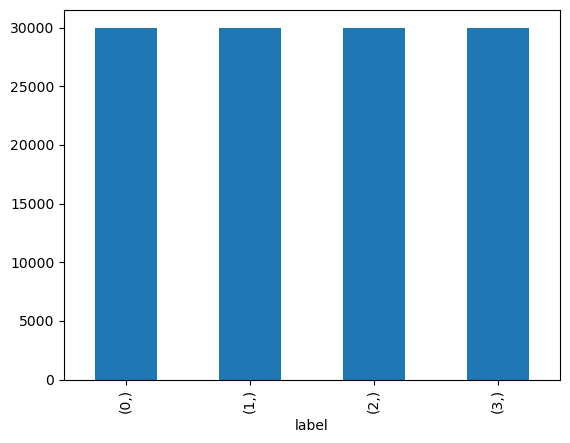

In [53]:
dataset.select_columns('label').to_pandas().value_counts().plot(kind="bar");

As you can see, we have an very well-balanced dataset at our disposal. Let's look at the average length of news per class label.

In [ ]:
(
    dataset.to_pandas()
           .apply(len).value_counts().plot(kind="bar");)

In [6]:
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

num_labels = len(id2label)

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model
import numpy as np
import torch

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')#.to(device)

In [8]:
tokenizer.eos_token

'<|endoftext|>'

In [9]:
tokenizer.pad_token = tokenizer.eos_token

In [10]:
text = "What does a cow use to do math? A cow-culator."
em = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")#.to(device)
em

{'input_ids': tensor([[ 2061,   857,   257,  9875,   779,   284,   466, 10688,    30,   317,
          9875,    12,  3129,  1352,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [11]:
with torch.no_grad():
    embs = model(**em)
embs

BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[-0.1643,  0.0957, -0.2844,  ..., -0.1632, -0.0774, -0.2154],
         [ 0.0472,  0.2181,  0.0754,  ...,  0.0281,  0.2386, -0.0731],
         [-0.1410,  0.1957,  0.5674,  ..., -0.4050,  0.1199, -0.0043],
         ...,
         [ 0.0686,  0.2000,  0.2881,  ...,  0.2151, -0.5111, -0.2907],
         [-0.0662,  0.3934, -0.8001,  ...,  0.2597, -0.1465, -0.1695],
         [-0.1900, -0.2704, -0.3135,  ...,  0.3318, -0.4120, -0.0153]]]), past_key_values=((tensor([[[[-1.3190e+00,  1.8644e+00,  8.9757e-01,  ..., -1.4033e+00,
           -2.3651e-01,  1.2896e+00],
          [-2.1018e+00,  1.8128e+00,  1.9426e+00,  ..., -1.1765e+00,
           -2.1712e+00,  2.2985e+00],
          [-2.3145e+00,  2.7101e+00,  1.5073e+00,  ..., -5.7809e-01,
           -1.9292e+00,  2.2634e+00],
          ...,
          [-2.7179e+00,  3.0262e+00,  1.6974e+00,  ..., -1.3679e+00,
            4.0493e-01,  1.2000e+00],
          [-2.1262e+00,  2.1460e+00,

In [12]:
embs.last_hidden_state.size()

torch.Size([1, 15, 768])

In [13]:
def mean_pooling(model_output, attention_mask):

    token_embeddings = model_output[0]
    input_mask_expanded = (attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float())
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(
        examples["text"], padding=True, truncation=True, return_tensors="pt"
    )#.to(device)
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

In [14]:
small_set = (
    dataset.shuffle(42)
           .select(range(1000))
           .map(embed_text, batched=True, batch_size=128)
)

Loading cached shuffled indices for dataset at /home/ramonperez/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-dd0ff9596fea92b0.arrow
Loading cached processed dataset at /home/ramonperez/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-8ecc41bbf0dace1b.arrow


In [15]:
small_set[:2]

{'text': ['Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.',
  'Desiring Stability Redskins coach Joe Gibbs expects few major personnel changes in the offseason and wants to instill a culture of stability in Washington.'],
 'label': [0, 1],
 'embedding': [[-0.13398756086826324,
   0.3544670343399048,
   -0.1633017361164093,
   -0.011828236281871796,
   0.05845893174409866,
   -0.3131028115749359,
   0.6775457859039307,
   0.10476072132587433,
   0.09056395292282104,
   -0.008192075416445732,
   0.2373136579990387,
   0.11444969475269318,
   0.38163065910339355,
   -0.01913348212838173,
   -0.03800442814826965,
   -0.08309228718280792,
   0.224115788936615,
   0.1840844452381134,
   0.20107637345790863,
   -0.7929673194885254,
   -0.12484019994735718,
   0.08396953344345093,
   -0.3460885286331177,
   0.0736243724822998,
   0.5198572278022766,
   0.1391483992

In [16]:
len(small_set)

1000

In [17]:
n_rows = range(len(small_set))
small_set = small_set.add_column("idx", n_rows)
small_set

Dataset({
    features: ['text', 'label', 'embedding', 'idx'],
    num_rows: 1000
})

In [18]:
small_set['idx'][-10:]

[990, 991, 992, 993, 994, 995, 996, 997, 998, 999]

In [19]:
def get_names(label_num):
    return id2label[str(label_num)]

label_names = list(map(get_names, small_set['label']))
small_set = small_set.add_column("label_names", label_names)
small_set

Dataset({
    features: ['text', 'label', 'embedding', 'idx', 'label_names'],
    num_rows: 1000
})

In [20]:
dim_size = len(small_set[0]["embedding"])

In [21]:
my_2nd_collection = "news_embeddings"
second_collection = client.recreate_collection(
    collection_name=my_2nd_collection,
    vectors_config=models.VectorParams(size=dim_size, distance=models.Distance.COSINE)
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 my_2nd_collection = "news_embeddings"                                                        │
│ ❱ 2 second_collection = client.recreate_collection(                                              │
│   3 │   collection_name=my_2nd_collection,                                                       │
│   4 │   vectors_config=models.VectorParams(size=dim_size, distance=models.Distance.COSINE)       │
│   5 )                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'client' is not defined

In [ ]:
payloads = small_set.select_columns(["label_names", "text"]).to_pandas().to_dict(orient="records")
payloads[:3]

In [ ]:
client.upsert(
    collection_name=my_2nd_collection,
    points=models.Batch(
        ids=small_set["idx"],
        vectors=small_set["embedding"],
        payloads=payloads
    )
)

In [ ]:
query1 = small_set[100]['embedding']
small_set[100]['text'], query1[:7]

In [ ]:
client.search(
    collection_name=my_2nd_collection,
    query_vector=query1,
    limit=10
)

In [ ]:
from random import choice
query2 = {"text": dataset[choice(range(len(dataset)))]['text']}
query2

In [ ]:
query2 = embed_text(query2)['embedding'][0, :]
query2.shape, query2

In [ ]:
query2.tolist()

In [ ]:
client.search(
    collection_name=my_2nd_collection,
    query_vector=query2.tolist(),
    limit=10
)

In [ ]:
business = models.Filter(
    must=[
        models.FieldCondition(
            key="label_names",
            match=models.MatchValue(value="Business")
    )
    ]
)

In [ ]:
client.search(
    collection_name=my_2nd_collection,
    query_vector=query2.tolist(),
    query_filter=business,
    limit=5
)

In [ ]:
# we can check that our collection was indeed created with
client.get_collections()

In [39]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import umap
import umap.plot
import matplotlib.pyplot as plt

In [41]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(small_set['embedding'])
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine", n_neighbors=4).fit(X_scaled)

In [42]:
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = small_set['label_names']
df_emb.head()

,X,Y,label
0,9.064930,12.231162,World
1,9.263160,5.800678,Sports
2,8.238400,13.082876,World
3,1.694636,7.478408,Sci/Tech
4,8.133162,12.223301,World


In [43]:
df_emb.label.unique(), small_set.features["label"].names

(array(['World', 'Sports', 'Sci/Tech', 'Business'], dtype=object),
 ['World', 'Sports', 'Business', 'Sci/Tech'])

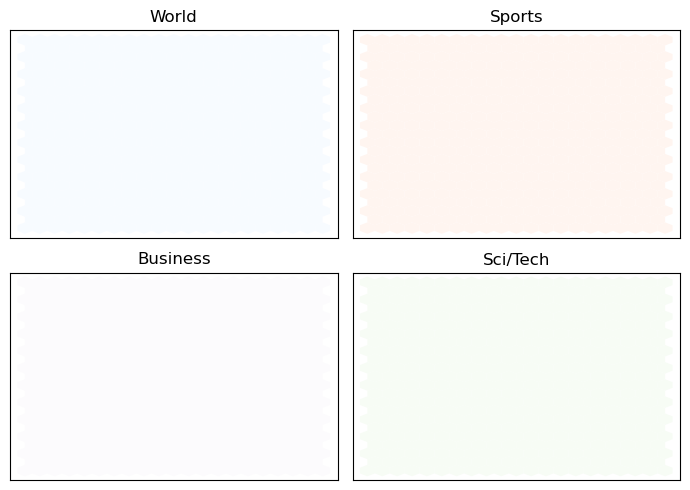

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Blues", "Reds", "Purples", "Greens"]
labels = small_set.features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

<Axes: >

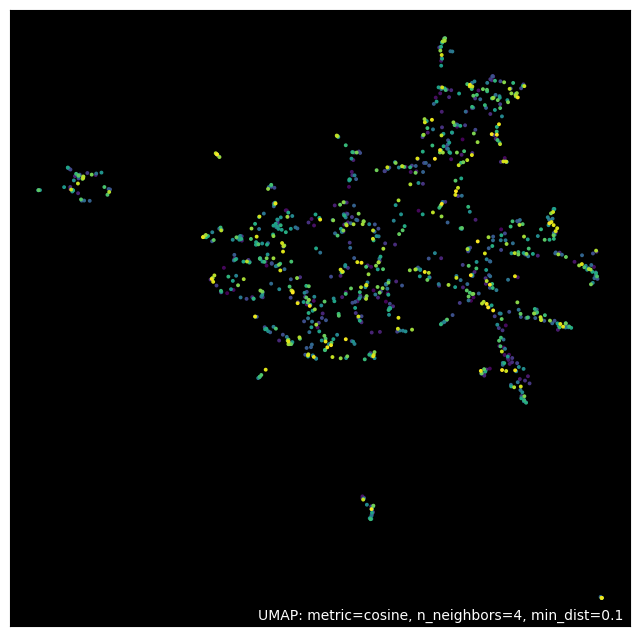

In [45]:
umap.plot.points(mapper, values=np.arange(1000), theme='viridis')

## 5. Conclusion